Source data file & detailed info on the dataset: https://www.kaggle.com/residentmario/ramen-ratings

This dataset compares the ratings of a wide variety of ramen across the features Brand, Style (of packaging), and Country of manufacture. The analysis compares those features to the 'Stars' rating scale (1 - 5 stars) to determine if those features can predict how good the ramen is.

# **Table of Contents**

[Imports](#Imports)

[Initial EDA w/Pandas](#Initial-EDA-w/Pandas)

[Which styles have the best/worst ratings?](#Which-styles-have-the-best/worst-ratings?)

> [Ratings by Style Boxplot](#Ratings-by-Style-Boxplot)

> [Style Distribution Histograms](#Style-Distribution-Histograms)

> [Tests for Normality: Shapiro-Wilk Test and Quantile-Quantile Plots](#Shapiro-Wilk-Test-and-Quantile-Quantile-Plots)

> [Hypothesis Testing - Kruskal Wallis Test](#Kruskal-Wallis-Test)

> [Hypothesis Testing - Dunn's Test](#Dunn's-Test)

> [Style-Ratings Results](#Style-Ratings-Results)

[Which countries make the best/worst ramen?](#Which-countries-make-the-best/worst-ramen?)

> [Country-Stars Boxplot (Presentation-Grade Visualization)](#Country-Stars-Boxplot)

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, shapiro, probplot, kruskal, ranksums
from scikit_posthocs import posthoc_dunn
from itertools import combinations

# Initial EDA w/Pandas

In [2]:
# Create DataFrame from .csv
df = pd.read_csv('ramen-ratings.csv')

# Preliminary look at the data
print(df.head(), '\n')
print(df.info())

   Review #           Brand  \
0      2580       New Touch   
1      2579        Just Way   
2      2578          Nissin   
3      2577         Wei Lih   
4      2576  Ching's Secret   

                                             Variety Style Country Stars  \
0                          T's Restaurant Tantanmen    Cup   Japan  3.75   
1  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack  Taiwan     1   
2                      Cup Noodles Chicken Vegetable   Cup     USA  2.25   
3                      GGE Ramen Snack Tomato Flavor  Pack  Taiwan  2.75   
4                                    Singapore Curry  Pack   India  3.75   

  Top Ten  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-

In [3]:
# Check for duplicate values
duplicates = df.duplicated()
duplicates.value_counts()

False    2580
dtype: int64

The DataFrame has 2580 rows and 7 columns and no duplicated rows. `Top Ten` only has 41 rows with data, and `Style` has 2 rows with missing data. We can also see that the `Stars` column has dtype "object" when we would expect it to be "float". That column would be really useful in an analysis so let's see if it needs more cleanup than just a dtype change.

In [4]:
# Look at the possible values for the "Stars" column
df['Stars'].unique()

array(['3.75', '1', '2.25', '2.75', '4.75', '4', '0.25', '2.5', '5',
       '4.25', '4.5', '3.5', 'Unrated', '1.5', '3.25', '2', '0', '3',
       '0.5', '4.00', '5.0', '3.50', '3.8', '4.3', '2.3', '5.00', '3.3',
       '4.0', '3.00', '1.75', '3.0', '4.50', '0.75', '1.25', '1.1', '2.1',
       '0.9', '3.1', '4.125', '3.125', '2.125', '2.9', '0.1', '2.8',
       '3.7', '3.4', '3.6', '2.85', '3.2', '3.65', '1.8'], dtype=object)

This column would best be converted to float values, but there's an "Unrated" label in there that prevents us from doing any math on that column. Let's drop those rows from our data.

In [5]:
# Replace "Unrated" with NaN
df.replace('Unrated', np.NaN, inplace=True)
df.dropna(subset=['Stars'], axis=0, inplace=True)

# Set column dtype to float
df['Stars'] = df['Stars'].astype('float')

What questions could we ask about this data?

- Is packaging style a predictor of how good the ramen will be (the Stars rating)?
- What countries make the best ramen? The worst?

# Which styles have the best/worst ratings?

In [6]:
# Get average rating and count by style
style_ratings = df.groupby('Style')['Stars'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print(style_ratings)

           mean  count
Style                 
Bar    5.000000      1
Box    4.291667      6
Pack   3.700458   1528
Bowl   3.670686    481
Tray   3.545139    108
Can    3.500000      1
Cup    3.498500    450


It looks like a few categories have minimal data available and we have to decide whether or not to include them. A category only having a single data point (or only a small handful) could easily misrepresent the data. In this case it would probably be best to drop the "Bar", "Box", and "Can" styles from the analysis, but include a note about that decision in any write-up or presentation.

In [7]:
# Drop the "Bar", "Box", and "Can" styles from the data due to extremely low value counts
select_styles_df = df[df['Style'].isin(['Pack', 'Bowl', 'Tray', 'Cup'])]
style_ratings = select_styles_df \
    .groupby('Style')['Stars'] \
    .agg(['mean', 'count']) \
    .sort_values(by='mean', ascending=False)
print(style_ratings)

           mean  count
Style                 
Pack   3.700458   1528
Bowl   3.670686    481
Tray   3.545139    108
Cup    3.498500    450


These mean rating values are all pretty similar. We can show that visually.

# Ratings by Style Boxplot

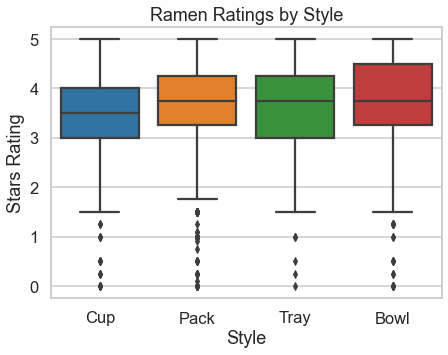

In [8]:
# Create boxplot of style data
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(7, 5))
sns.boxplot(data=select_styles_df,
            x='Style',
            y='Stars')
plt.title('Ramen Ratings by Style')
plt.ylabel('Stars Rating')
plt.show()

Visually, the ramen appears to get pretty consistent ratings regardless of packaging style. However, a small boost in ratings could place the product higher up in search results, leading to more customers seeing the product and ultimately purchasing it. Another application of this thought process would be if the ratings were the results from a marketing survey on different packaging types, and we wanted to see if customers were more likely to buy the product if it came in different packaging.

Let's do some statistics to see if there's a significant difference between the means of the categories that is difficult to see from the box plot. This typically would call for ANOVA and potentially a Tukey's test, but ANOVA requires a few statistical assumptions to be true, conveniently accessible by typing `help(f_oneway)`:

- The samples are independent
- Each sample is from a normally distributed population
- The population standard deviation of the groups are all equal

The second bullet point (and possibly the third) may present an issue. For statistical assessments of normality, we can check by two methods: a Shapiro-Wilk test or a Q-Q plot. Shapiro-Wilk is only useful for small sample sizes, as it is overly sensitive to departures from normality as sample sizes grow larger.  However, the first thing to do would be to simply look at the distribution of each population and see if they exhibit the characteristic symmetrical bell curve of a normal distribution.

# Style Distribution Histograms

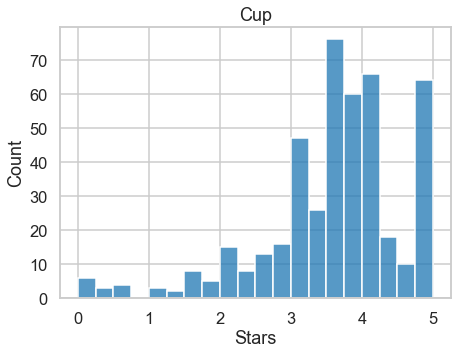

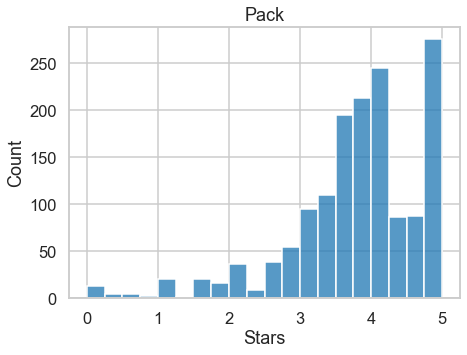

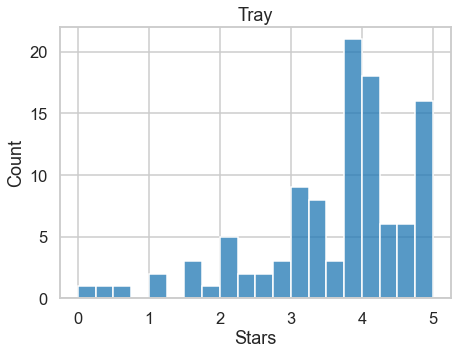

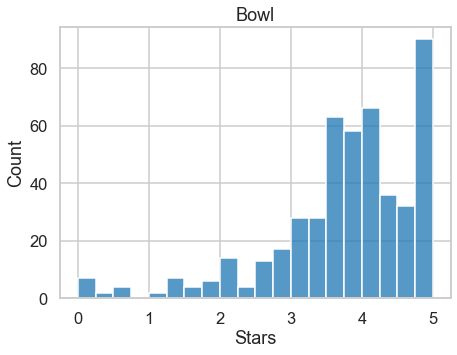

In [9]:
# Choose styles to plot
styles_list = ['Cup', 'Pack', 'Tray', 'Bowl']

for style in styles_list:
    
    # Subset the data to the particular style
    data = select_styles_df['Stars'][select_styles_df['Style'] == style]
    
    # Create histogram
    sns.set_context('talk')
    sns.set_style('whitegrid')
    
    fig = plt.figure(figsize=(7, 5))
    sns.histplot(data=data, bins=20)
    plt.title(style)
    plt.show()

These distributions are blatantly non-normal! They all show left-tailed skewedness and are multimodal. This means that an ANOVA would not be statistically valid. Although these histograms are enough evidence to make these claims, we'll still assess normality by doing Shapiro-Wilk tests and some Q-Q plots just for fun.

# Shapiro-Wilk Test and Quantile-Quantile Plots

The Shapiro-Wilk test will output a test statistic and a p-value to test the null hypothesis that a population is normally distributed. It's mostly being done for fun in this instance, as it is overly sensitive to departures from normality in larger datasets. The histograms and quantile-quantile plots are the better assessments in this case.

Cup p-value: 4.003543576844813e-15
We REJECT the null hypothesis that the Cup population is distributed normally.

Pack p-value: 3.4777901267947846e-29
We REJECT the null hypothesis that the Pack population is distributed normally.

Tray p-value: 2.165302703360794e-06
We REJECT the null hypothesis that the Tray population is distributed normally.

Bowl p-value: 3.9084068876171294e-17
We REJECT the null hypothesis that the Bowl population is distributed normally.



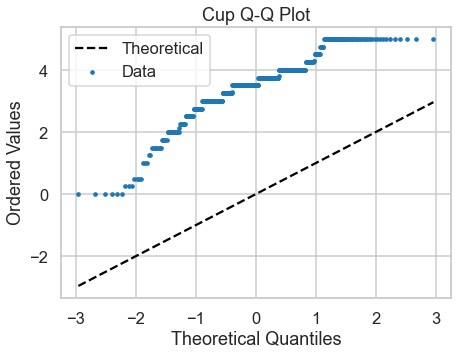

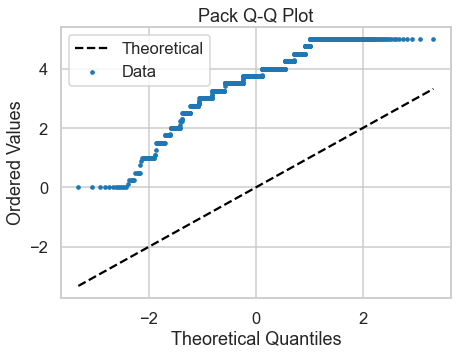

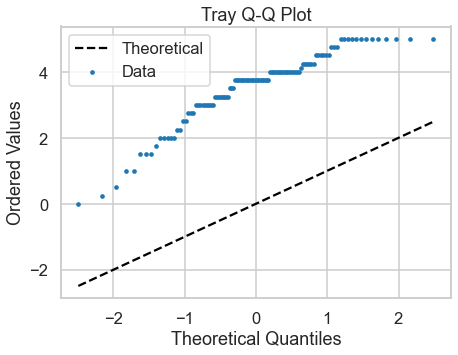

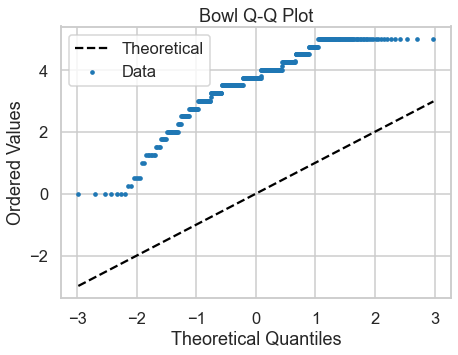

In [10]:
# Shapiro-Wilk
# Use the styles_list that was originally created for the histograms 
for style in styles_list:
    
    # Subset the Stars data for a given style
    shapiro_data = select_styles_df[select_styles_df['Style'] == style]['Stars']
    
    # Perform the Shapiro-Wilk test
    stat, pval = shapiro(shapiro_data)
    
    # Print results
    print(f'{style} p-value: {str(pval)}')
    if pval <= 0.05:
        print(f'We REJECT the null hypothesis that the {style} population is distributed normally.\n')
    else:
        print(f'We FAIL TO REJECT the null hypothesis that the {style} population is distributed normally.\n')

# Q-Q plots
for style in styles_list:
    
    # Create theoretical quantiles
    theoretical_quantiles = probplot(select_styles_df[select_styles_df['Style'] == style]['Stars'], dist='norm')
    
    # Select data
    x_data = theoretical_quantiles[0][0]
    y_data = select_styles_df[select_styles_df['Style'] == style]['Stars'].sort_values()
    
    # Create plots
    sns.set_context('talk')
    sns.set_style('whitegrid')
    
    fig = plt.figure(figsize=(7, 5))
    plt.scatter(x_data, y_data, label='Data', s=10)
    plt.plot(x_data, x_data, color="k", ls="--", label='Theoretical')
    plt.title(f'{style} Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.legend()
    plt.show()

If the data was from a normal distribution, it would create an approximately straight line that overlaid the theoretical quantile line. The data on these plots forms curves, indicating it is not from a normal distribution. It is also translated away from the theoretical quantile line, signifying skewedness.

# Kruskal-Wallis Test

An acceptable non-parametric alternative to ANOVA for use with non-normal distributions would be the Kruskal-Wallis H-test.

In [11]:
# Create variables that isolate the Stars ratings for each type of interest
style_cup = select_styles_df['Stars'][select_styles_df['Style'] == 'Cup']
style_pack = select_styles_df['Stars'][select_styles_df['Style'] == 'Pack']
style_tray = select_styles_df['Stars'][select_styles_df['Style'] == 'Tray']
style_bowl = select_styles_df['Stars'][select_styles_df['Style'] == 'Bowl']

# Perform Kruskal-Wallis H-test
hstat, pval = kruskal(style_cup, style_pack, style_tray, style_bowl)
print('Kruskal-Wallis p-value:', pval)
if pval <= 0.05:
    print('We reject the null hypothesis that all the populations are equal.\nAt least one of the populations tends to yield larger observations than\nat least one of the other populations.')
else:
    print('We fail to reject the null hypothesis that all the populations are equal')

Kruskal-Wallis p-value: 0.0003115023977099646
We reject the null hypothesis that all the populations are equal.
At least one of the populations tends to yield larger observations than
at least one of the other populations.


The Kruskal-Wallis test shows a significant difference between at least one pair of distributions.

# Dunn's Test

The follow-up test to the Kruskal-Wallis test is Dunn's Test. Dunn's is the non-parametric equivalent to Tukey's test, and is for performing multiple pairwise comparisons of non-normal distributions.

In [12]:
"""
The proper follow-up to a significant Kruskal-Wallis tests
is the Dunn test.
"""

# Create DataFrame with the relevant columns
dunn_df = select_styles_df[['Style', 'Stars']]

# Perform Dunn's test w/Sidak correction to control type 1 errors
dunn_results = posthoc_dunn(dunn_df,
                            val_col='Stars',
                            group_col='Style',
                            p_adjust='sidak')
print('Dunn Test Results:')
print(dunn_results, '\n')

Dunn Test Results:
          Bowl       Cup      Pack      Tray
Bowl  1.000000  0.003663  1.000000  0.907069
Cup   0.003663  1.000000  0.000196  0.837611
Pack  1.000000  0.000196  1.000000  0.885810
Tray  0.907069  0.837611  0.885810  1.000000 



The results from Dunn's test have statistically significant p-values for the Cup-Bowl and Cup-Pack pairs. This means that we would reject the null hypothesis that there is no difference between the groups.

Unfortunately, the results from Dunn's test are already a bit different to read, and would be even more difficult to read if there were many more pairings. Let's show how we make this MUCH more organized.

In [13]:
# Create list of possible pairing combinations
dunn_pairings = list(combinations(dunn_results.index, 2))
print(dunn_pairings)

[('Bowl', 'Cup'), ('Bowl', 'Pack'), ('Bowl', 'Tray'), ('Cup', 'Pack'), ('Cup', 'Tray'), ('Pack', 'Tray')]


In [14]:
# Create empty lists to store results
dunn_style_1 = []
dunn_style_2 = []
dunn_pvals = []

# Fill the lists with their respective data points
for i, j in dunn_pairings:
    dunn_style_1.append(i)
    dunn_style_2.append(j)
    dunn_pvals.append(dunn_results.at[i, j])

# Create clean-looking DataFrame
dunn_results_clean = pd.DataFrame({'Style 1': dunn_style_1,
                                   'Style 2': dunn_style_2,
                                   'p-value': dunn_pvals})

print(dunn_results_clean)

  Style 1 Style 2   p-value
0    Bowl     Cup  0.003663
1    Bowl    Pack  1.000000
2    Bowl    Tray  0.907069
3     Cup    Pack  0.000196
4     Cup    Tray  0.837611
5    Pack    Tray  0.885810


In [15]:
# Filter the results to only show significant p-values
dunn_results_sig = dunn_results_clean[dunn_results_clean['p-value'] <= 0.05]
print(dunn_results_sig)

  Style 1 Style 2   p-value
0    Bowl     Cup  0.003663
3     Cup    Pack  0.000196


We would reject the null hypothesis that there is no difference between the groups.

It seems like there's something about the Cup style that tends to set it apart from the others. Let's remind ourselves of where it stood:

# Style-Ratings Results

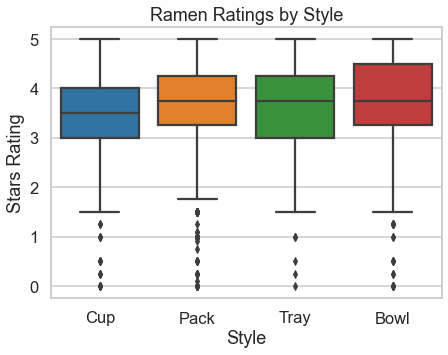

In [16]:
# Same boxplot that was created previously
sns.set_context('talk')
sns.set_style('whitegrid')

# Create boxplot of style data
fig = plt.figure(figsize=(7, 5))
sns.boxplot(data=select_styles_df,
            x='Style',
            y='Stars')
plt.title('Ramen Ratings by Style')
plt.ylabel('Stars Rating')
plt.show()

The significant difference shown in both the Cup-Pack and Cup-Bowl pairings make sense.

**Ramen that comes in Cup packaging is of statistically lower average quality than that which comes in the Pack or Bowl packaging.**

# Which countries make the best/worst ramen?

In [17]:
# Select the data
country_ratings = df.groupby('Country')['Stars'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print(country_ratings)

                   mean  count
Country                       
Brazil         4.350000      5
Sarawak        4.333333      3
Cambodia       4.200000      5
Malaysia       4.154194    155
Singapore      4.126147    109
Indonesia      4.067460    126
Japan          3.981605    352
Myanmar        3.946429     14
Fiji           3.875000      4
Hong Kong      3.801825    137
South Korea    3.790554    307
United States  3.750000      1
Mexico         3.730000     25
Bangladesh     3.714286      7
Taiwan         3.665402    224
Germany        3.638889     27
Poland         3.625000      4
Hungary        3.611111      9
Dubai          3.583333      3
Finland        3.583333      3
Holland        3.562500      4
Nepal          3.553571     14
Estonia        3.500000      2
Ghana          3.500000      2
USA            3.457043    323
China          3.421893    169
India          3.395161     31
Thailand       3.384817    191
Philippines    3.329787     47
Colombia       3.291667      6
Sweden  

Upon close inspection, there's a small problem! The United States is listed twice - once as "United States", and 323 times as "USA". We should combine these. Also, Sarawak (with the 2nd highest mean Stars rating), is a state within Malaysia and should be renamed to 'Malaysia'.

In [18]:
# Subset for Country and Stars column
country_ratings_df = df[['Country', 'Stars']]

# Replace country label 'USA' with 'United States'
country_ratings_df = country_ratings_df.replace(to_replace='USA', value='United States')

# Replace country label 'Sarawak' with 'Malaysia'
country_ratings_df = country_ratings_df.replace(to_replace='Sarawak', value='Malaysia')

# Country-Stars Boxplot

In [19]:
# Sorts countries by their Stars rating to set x-axis plotting order
country_ratings_grouped = country_ratings_df.loc[:,['Country', 'Stars']] \
    .groupby(['Country']) \
    .mean() \
    .sort_values(by='Stars')

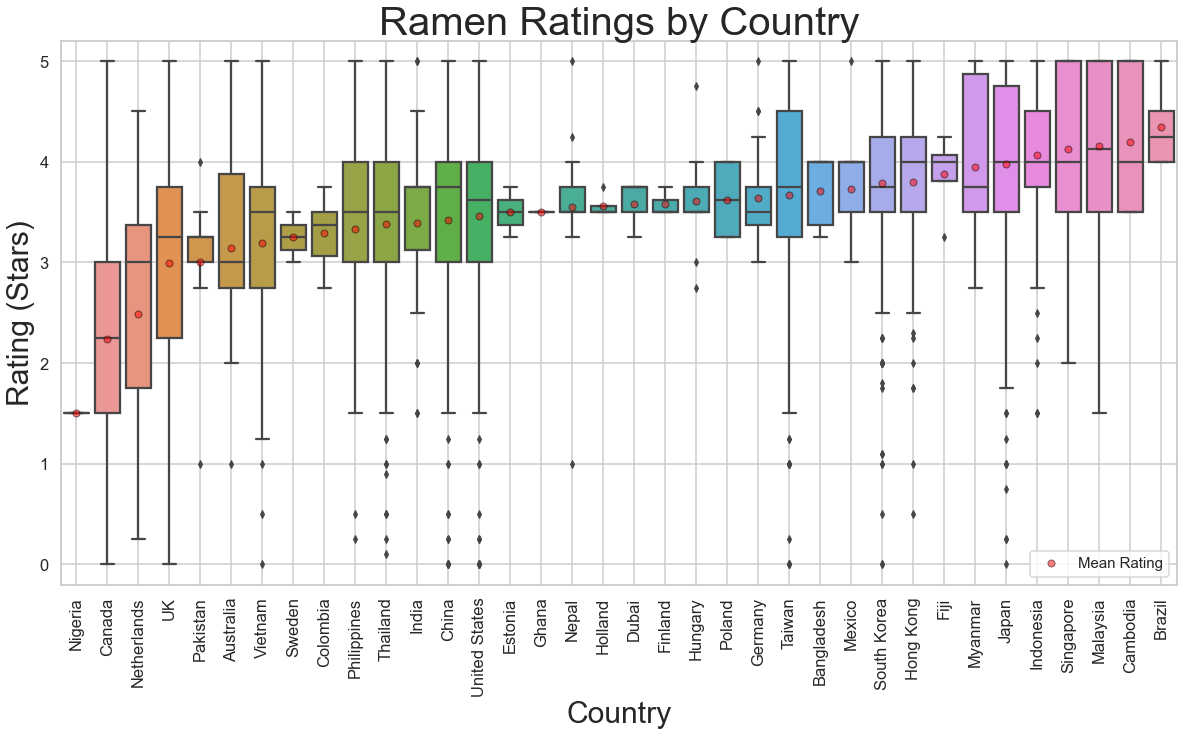

In [20]:
# Boxplot
# Jupyter Notebook displays plots in a tiny size, so I'll oversize this one
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(20, 10))
sns.boxplot(data=country_ratings_df,
            x='Country',
            y='Stars',
            order=country_ratings_grouped.index,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'black',
                       'markersize':'7',
                       'alpha':0.5})
plt.ylim(-0.2, 5.2)
means_dummy = plt.plot(0, -1,
                       linestyle='None',
                       marker='o',
                       markerfacecolor='red',
                       markeredgecolor='black',
                       markersize=7,
                       alpha=0.5,
                       label='Mean Rating')
plt.title('Ramen Ratings by Country', size=40)
plt.xlabel('Country', size=30)
plt.ylabel('Rating (Stars)', size=30)
plt.xticks()
plt.yticks()
plt.grid(axis='x')
plt.xticks(rotation=90)
plt.legend(means_dummy, ['Mean Rating'], fontsize=15)
plt.show()

It might not surprise anyone to see that the right side of the chart, which shows the countries with higher mean ramen ratings, is dominated by east and southeast Asia. A result that may be surprising to many people was that Brazil had the highest average ramen rating!

It should be noted however that unlike the packaging style comparison, the data on this boxplot was not filtered to remove countries with low value counts (such as that clump of small boxes in the center of the plot). What would the data look like if we only showed countries with a minimum of 10 ratings?

In [21]:
# Subset the DataFrame for countries that have at least 10 ratings
country_ratings_gthan10 = country_ratings_df[df['Country'] \
    .isin(df['Country'].value_counts()[df['Country'].value_counts() >= 10].index)] \
    .reset_index()
print(country_ratings_gthan10)

      index        Country  Stars
0         0          Japan   3.75
1         1         Taiwan   1.00
2         2  United States   2.25
3         3         Taiwan   2.75
4         4          India   3.75
...     ...            ...    ...
2501   2575        Vietnam   3.50
2502   2576       Thailand   1.00
2503   2577       Thailand   2.00
2504   2578       Thailand   2.00
2505   2579  United States   0.50

[2506 rows x 3 columns]


In [22]:
# Sorts countries by their Stars rating to set x-axis plotting order
country_ratings_gthan10_grouped = country_ratings_gthan10.loc[:,['Country', 'Stars']] \
    .groupby(['Country']) \
    .mean() \
    .sort_values(by='Stars')

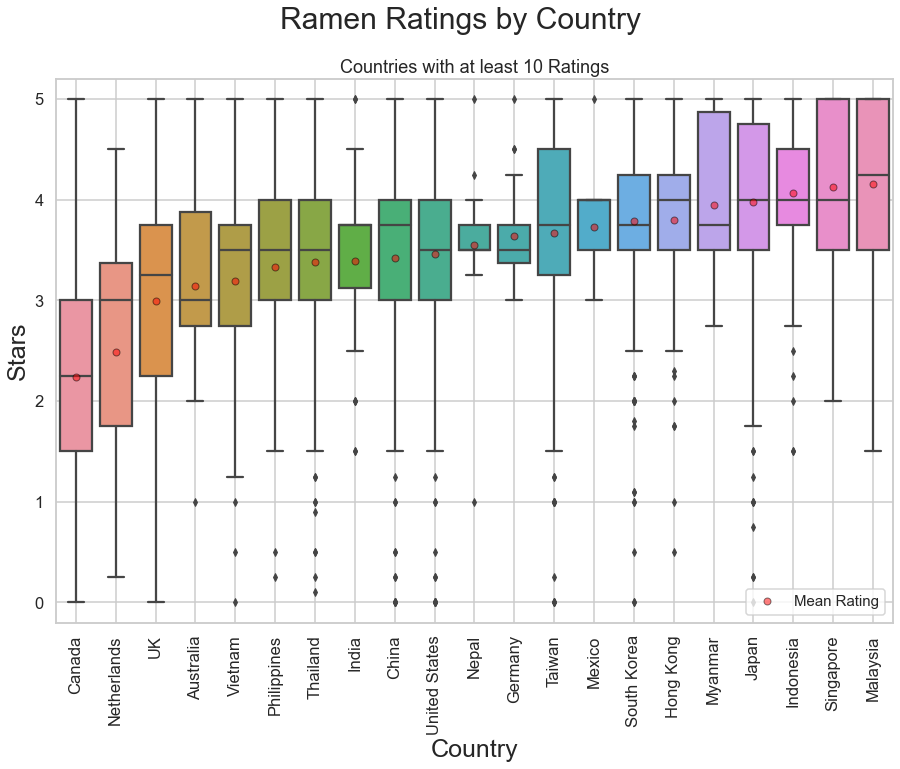

In [23]:
# Boxplot
# Jupyter Notebook displays plots in a tiny size, so I'll oversize this one
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(15, 10))
sns.boxplot(data=country_ratings_gthan10,
            x='Country',
            y='Stars',
            order=country_ratings_gthan10_grouped.index,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'black',
                       'markersize':'7',
                       'alpha':0.5})
plt.ylim(-0.2, 5.2)
means_dummy = plt.plot(0, -1,
                       linestyle='None',
                       marker='o',
                       markerfacecolor='red',
                       markeredgecolor='black',
                       markersize=7,
                       alpha=0.5,
                       label='Mean Rating')
plt.suptitle('Ramen Ratings by Country', size=30)
plt.title('Countries with at least 10 Ratings')
plt.xlabel('Country', size=25)
plt.ylabel('Stars', size=25)
plt.xticks()
plt.yticks()
plt.grid(axis='x')
plt.xticks(rotation=90)
plt.legend(means_dummy, ['Mean Rating'], fontsize=15)
plt.show()